In [1]:
"""
KNN (K-NEAREST NEIGHBORS) PARA CLASIFICACIÓN DE ENFERMEDADES DE CEBOLLA
"""
#Importación de librerias
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

#Librerias para guardar archivos
import joblib
from pathlib import Path
out_dir = Path.cwd() / "KNN" #Carpeta para guardar y cargar los modelos de KNN
out_dir.mkdir(parents=True, exist_ok=True)

Función para cargar los archivos desde el CSV

In [5]:
def cargar_datos_desde_csv(csv_path='onion_dataset.csv', tamano_imagen=(32, 32)):
    """
    Carga las imágenes desde el CSV y las convierte a vectores de características.
    """
    
    print("="*60)
    print("CARGANDO DATASET")
    print("="*60)
    
    df = pd.read_csv(csv_path)
    print(f"Archivo CSV cargado: {len(df)} imágenes encontradas")
    
    clases_unicas = df['class'].unique()
    print(f"Clases encontradas: {len(clases_unicas)}")
    for i, clase in enumerate(clases_unicas, 1):
        print(f"   {i}. {clase}")
    
    X = []
    y = []
    errores = 0
    
    print(f"\nProcesando imágenes (tamaño: {tamano_imagen})...")
    
    for idx, fila in df.iterrows():
        try:
            imagen = Image.open(fila['image_path'])
            
            if imagen.mode != 'RGB':
                imagen = imagen.convert('RGB')
            
            imagen = imagen.resize(tamano_imagen)
            imagen_array = np.array(imagen).flatten()
            imagen_normalizada = imagen_array / 255.0
            
            X.append(imagen_normalizada)
            y.append(fila['class'])
            
            if (idx + 1) % 100 == 0:
                print(f"   Procesadas: {idx + 1}/{len(df)}")
                
        except Exception as e:
            errores += 1
    
    X = np.array(X)
    y = np.array(y)
    
    print(f"\nProcesamiento completado")
    print(f"   Imágenes procesadas: {len(X)}")
    print(f"   Errores: {errores}")
    print(f"   Forma de X: {X.shape}")
    print(f"   Número de características: {X.shape[1]}")
    
    return X, y, clases_unicas

Función para encontrar el mejor K utilizando validación Cruzada

In [6]:
def encontrar_mejor_k(X_train, y_train, k_range=None):
    """
    Encuentra el mejor valor de K usando validación cruzada.
    """
    
    print("\n" + "="*60)
    print("BÚSQUEDA DEL MEJOR K")
    print("="*60)
    
    if k_range is None:
        k_range = range(1, min(31, len(X_train)//10), 2)  # Solo K impares para evitar empates
    
    mejores_scores = []
    k_valores = []
    
    print("Probando diferentes valores de K con validación cruzada...")
    
    for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
        scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
        score_promedio = scores.mean()
        mejores_scores.append(score_promedio)
        k_valores.append(k)
        print(f"   K={k}: Accuracy promedio = {score_promedio:.4f}")
    
    mejor_k = k_valores[np.argmax(mejores_scores)]
    mejor_score = max(mejores_scores)
    
    print(f"\nMejor K encontrado: {mejor_k}")
    print(f"Score de validación cruzada: {mejor_score:.4f}")
    
    # Graficar resultados
    plt.figure(figsize=(10, 6))
    plt.plot(k_valores, mejores_scores, 'bo-')
    plt.xlabel('Valor de K')
    plt.ylabel('Accuracy de Validación Cruzada')
    plt.title('Selección del Mejor K para KNN')
    plt.grid(True, alpha=0.3)
    plt.axvline(x=mejor_k, color='red', linestyle='--', label=f'Mejor K={mejor_k}')
    plt.legend()
    plt.savefig(out_dir/'seleccion_k_knn.png', dpi=100, bbox_inches='tight')
    plt.show()
    
    return mejor_k

Función para entrenar modelo KNN

In [7]:
def entrenar_knn(X_train, y_train, n_neighbors=5):
    """
    Entrena un modelo KNN.
    """
    
    print("\n" + "="*60)
    print("ENTRENANDO KNN")
    print("="*60)
    
    modelo = KNeighborsClassifier(
        n_neighbors=n_neighbors,
        weights='uniform',  # 'uniform' o 'distance'
        algorithm='auto',   # 'auto', 'ball_tree', 'kd_tree', 'brute'
        metric='minkowski',
        p=2,  # p=2 para distancia Euclidiana
        n_jobs=-1  # Usar todos los cores disponibles
    )
    
    print(f"Entrenando KNN con K={n_neighbors}...")
    print(f"   Algoritmo: {modelo.algorithm}")
    print(f"   Métrica de distancia: {modelo.metric}")
    print(f"   Ponderación: {modelo.weights}")
    
    modelo.fit(X_train, y_train)
    
    print("Modelo entrenado exitosamente")
    
    return modelo

Función para evaluar Modelo

In [8]:
def evaluar_modelo(modelo, X_test, y_test, nombres_clases):
    """
    Evalúa el modelo y muestra métricas.
    """
    
    print("\n" + "="*60)
    print("EVALUACIÓN DEL MODELO KNN")
    print("="*60)
    
    # Hacer predicciones
    y_pred = modelo.predict(X_test)
    
    # Calcular accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\nACCURACY GENERAL: {accuracy:.4f} ({accuracy*100:.2f}%)")
    
    # Mostrar información del modelo
    print(f"\nInformación del modelo:")
    print(f"   K (vecinos): {modelo.n_neighbors}")
    print(f"   Número de muestras de entrenamiento: {modelo.n_samples_fit_}")
    
    # Reporte de clasificación
    print("\nREPORTE DETALLADO POR CLASE:")
    print("-"*60)
    reporte = classification_report(y_test, y_pred, target_names=nombres_clases, zero_division=0)
    print(reporte)
    
    # Calcular matriz de confusión
    matriz_confusion = confusion_matrix(y_test, y_pred)
    
    return accuracy, y_pred, matriz_confusion

Función para analizar vecinos más cercanos

In [9]:
def analizar_vecinos_mas_cercanos(modelo, X_test, y_test, X_train, y_train, n_ejemplos=5):
    """
    Analiza los vecinos más cercanos para algunos ejemplos de prueba.
    """
    
    print("\n" + "="*60)
    print("ANÁLISIS DE VECINOS MÁS CERCANOS")
    print("="*60)
    
    # Seleccionar ejemplos aleatorios
    indices_aleatorios = np.random.choice(len(X_test), min(n_ejemplos, len(X_test)), replace=False)
    
    for i, idx in enumerate(indices_aleatorios):
        # Encontrar vecinos más cercanos
        distancias, indices = modelo.kneighbors([X_test[idx]], n_neighbors=modelo.n_neighbors)
        
        print(f"\nEjemplo {i+1}:")
        print(f"   Clase real: {y_test[idx]}")
        
        # Contar clases de los vecinos
        clases_vecinos = y_train[indices[0]]
        valores, conteos = np.unique(clases_vecinos, return_counts=True)
        
        print(f"   Vecinos encontrados:")
        for j, (dist, idx_vecino) in enumerate(zip(distancias[0], indices[0])):
            print(f"      {j+1}. Clase: {y_train[idx_vecino]}, Distancia: {dist:.4f}")
        
        print(f"   Votación:")
        for clase, count in zip(valores, conteos):
            print(f"      Clase {clase}: {count} votos")
        
        prediccion = modelo.predict([X_test[idx]])[0]
        print(f"   Predicción final: {prediccion}")

Función para visualizar matriz de confusión

In [10]:
def visualizar_matriz_confusion(matriz_confusion, nombres_clases):
    """
    Visualiza la matriz de confusión.
    """
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(matriz_confusion, 
                annot=True, 
                fmt='d', 
                cmap='Blues',
                xticklabels=nombres_clases,
                yticklabels=nombres_clases,
                cbar=True)
    plt.title('Matriz de Confusión - KNN', fontsize=14)
    plt.ylabel('Clase Real', fontsize=12)
    plt.xlabel('Clase Predicha', fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=9)
    plt.yticks(rotation=0, fontsize=9)
    plt.tight_layout()
    plt.savefig(out_dir/'matriz_confusion_knn.png', dpi=100, bbox_inches='tight')
    plt.show()

Función para analizar el impacto de K

In [11]:
def analizar_impacto_k(X_train, y_train, X_test, y_test, k_range=None):
    """
    Analiza cómo cambia el accuracy con diferentes valores de K.
    """
    
    print("\n" + "="*60)
    print("ANÁLISIS DEL IMPACTO DE K")
    print("="*60)
    
    if k_range is None:
        k_range = range(1, min(31, len(X_train)//10), 2)
    
    train_accuracies = []
    test_accuracies = []
    
    for k in k_range:
        # Entrenar modelo
        knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
        knn.fit(X_train, y_train)
        
        # Accuracy en entrenamiento
        train_acc = knn.score(X_train, y_train)
        train_accuracies.append(train_acc)
        
        # Accuracy en prueba
        test_acc = knn.score(X_test, y_test)
        test_accuracies.append(test_acc)
        
        print(f"   K={k}: Train={train_acc:.4f}, Test={test_acc:.4f}")
    
    # Graficar
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, train_accuracies, 'bo-', label='Entrenamiento')
    plt.plot(k_range, test_accuracies, 'ro-', label='Prueba')
    plt.xlabel('Valor de K')
    plt.ylabel('Accuracy')
    plt.title('Impacto de K en el Rendimiento')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(out_dir/'impacto_k_knn.png', dpi=100, bbox_inches='tight')
    plt.show()
    
    # Detectar sobreajuste/subajuste
    diferencias = np.array(train_accuracies) - np.array(test_accuracies)
    k_optimo = list(k_range)[np.argmin(diferencias)]
    print(f"\nK con menor diferencia train-test: {k_optimo}")
    print(f"Diferencia: {diferencias[list(k_range).index(k_optimo)]:.4f}")

Función para predecir nueva imagen

In [2]:
def predecir_imagen(ruta_imagen, modelo_path=out_dir/'modelo_knn.pkl'):
    """
    Predice la clase de una nueva imagen usando el modelo KNN entrenado
    y muestra la imagen con la clase predicha y su confianza.
    """
    import joblib
    from PIL import Image
    import numpy as np
    import matplotlib.pyplot as plt

    try:
        # Cargar modelo y transformadores
        modelo = joblib.load(modelo_path)
        scaler = joblib.load(out_dir/'scaler_knn.pkl')
        label_encoder = joblib.load(out_dir/'label_encoder_knn.pkl')

        # Cargar imagen original (para visualizar) y preparar para el modelo
        imagen_viz = Image.open(ruta_imagen)
        if imagen_viz.mode != 'RGB':
            imagen_viz = imagen_viz.convert('RGB')

        imagen_proc = imagen_viz.resize((32, 32))  # mismo tamaño que entrenamiento
        imagen_array = np.array(imagen_proc).flatten() / 255.0
        imagen_array = imagen_array.reshape(1, -1)

        # Escalar
        imagen_scaled = scaler.transform(imagen_array)

        # Vecinos más cercanos
        distancias, indices = modelo.kneighbors(imagen_scaled, n_neighbors=modelo.n_neighbors)

        # Predicción y probas
        prediccion = modelo.predict(imagen_scaled)[0]
        probabilidades = modelo.predict_proba(imagen_scaled)[0]
        confianza = float(np.max(probabilidades))

        # Decodificar
        clase_predicha = label_encoder.inverse_transform([prediccion])[0]

        # Logs en consola
        print(f"\nPREDICCIÓN:")
        print(f"   Clase: {clase_predicha}")
        print(f"   Confianza: {confianza:.2%}")
        print(f"\nVecinos más cercanos (K={modelo.n_neighbors}):")
        for i, (dist, idx) in enumerate(zip(distancias[0], indices[0])):
            print(f"   {i+1}. Distancia: {dist:.4f} (idx: {idx})")

        # Visualización
        plt.figure()
        plt.imshow(imagen_viz)
        plt.axis('off')
        plt.title(f"Predicción: {clase_predicha} | Confianza: {confianza:.2%}")
        plt.show()

        return clase_predicha

    except Exception as e:
        print(f"ERROR: {e}")
        return None


Parametros del modelo

In [13]:
CSV_PATH = 'onion_dataset.csv'
TAMANO_IMAGEN = (32, 32)
TEST_SIZE = 0.2

Entrenamiento del modelo

In [14]:
 # 1. Cargar datos
X, y, clases_unicas = cargar_datos_desde_csv(CSV_PATH, TAMANO_IMAGEN)

CARGANDO DATASET
Archivo CSV cargado: 13229 imágenes encontradas
Clases encontradas: 15
   1. Alternaria_D
   2. Botrytis Leaf Blight
   3. Bulb Rot
   4. Bulb_blight-D
   5. Caterpillar-P
   6. Downy mildew
   7. Fusarium-D
   8. Healthy leaves
   9. Iris yellow virus_augment
   10. Purple blotch
   11. Rust
   12. Virosis-D
   13. Xanthomonas Leaf Blight
   14. onion1
   15. stemphylium Leaf Blight

Procesando imágenes (tamaño: (32, 32))...
   Procesadas: 100/13229
   Procesadas: 200/13229
   Procesadas: 300/13229
   Procesadas: 400/13229
   Procesadas: 500/13229
   Procesadas: 600/13229
   Procesadas: 700/13229
   Procesadas: 800/13229
   Procesadas: 900/13229
   Procesadas: 1000/13229
   Procesadas: 1100/13229
   Procesadas: 1200/13229
   Procesadas: 1300/13229
   Procesadas: 1400/13229
   Procesadas: 1500/13229
   Procesadas: 1600/13229
   Procesadas: 1700/13229
   Procesadas: 1800/13229
   Procesadas: 1900/13229
   Procesadas: 2000/13229
   Procesadas: 2100/13229
   Procesadas: 2

In [15]:
# 2. Codificar etiquetas
print("\nCodificando etiquetas...")
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print("Mapeo de clases a números:")
for i, clase in enumerate(label_encoder.classes_):
    print(f"   {i}: {clase}")


Codificando etiquetas...
Mapeo de clases a números:
   0: Alternaria_D
   1: Botrytis Leaf Blight
   2: Bulb Rot
   3: Bulb_blight-D
   4: Caterpillar-P
   5: Downy mildew
   6: Fusarium-D
   7: Healthy leaves
   8: Iris yellow virus_augment
   9: Purple blotch
   10: Rust
   11: Virosis-D
   12: Xanthomonas Leaf Blight
   13: onion1
   14: stemphylium Leaf Blight


In [16]:
# 3. Dividir en entrenamiento y prueba
print("\nDividiendo datos...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, 
    test_size=TEST_SIZE, 
    random_state=42,
    stratify=y_encoded
)
print(f"   Entrenamiento: {len(X_train)} imágenes")
print(f"   Prueba: {len(X_test)} imágenes")


Dividiendo datos...
   Entrenamiento: 10583 imágenes
   Prueba: 2646 imágenes


In [17]:
# 4. Escalar características 
print("\nEscalando características...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("   Características escaladas (media=0, std=1)")


Escalando características...
   Características escaladas (media=0, std=1)



BÚSQUEDA DEL MEJOR K
Probando diferentes valores de K con validación cruzada...
   K=1: Accuracy promedio = 0.6774
   K=3: Accuracy promedio = 0.5320
   K=5: Accuracy promedio = 0.4635
   K=7: Accuracy promedio = 0.4349
   K=9: Accuracy promedio = 0.4180
   K=11: Accuracy promedio = 0.4068
   K=13: Accuracy promedio = 0.3949
   K=15: Accuracy promedio = 0.3873
   K=17: Accuracy promedio = 0.3812
   K=19: Accuracy promedio = 0.3761
   K=21: Accuracy promedio = 0.3690
   K=23: Accuracy promedio = 0.3674
   K=25: Accuracy promedio = 0.3637
   K=27: Accuracy promedio = 0.3624
   K=29: Accuracy promedio = 0.3608

Mejor K encontrado: 1
Score de validación cruzada: 0.6774


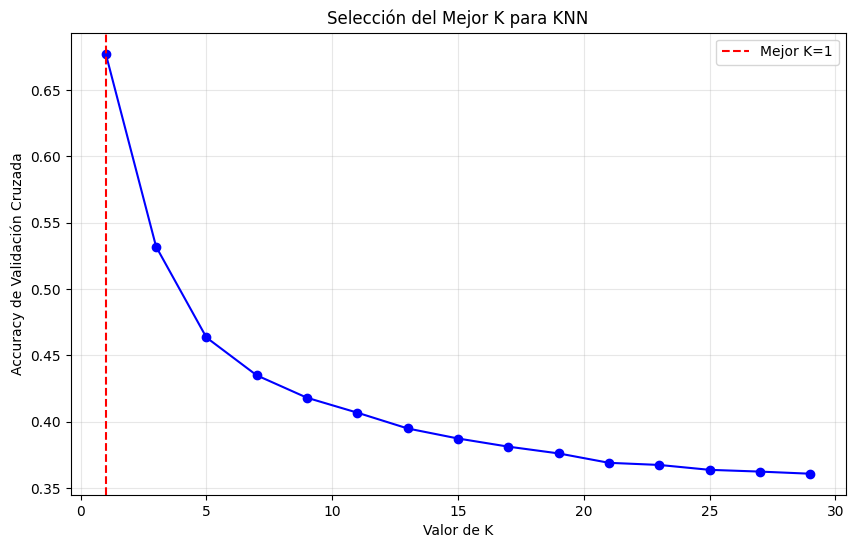

In [18]:
# 5. Encontrar mejor K
mejor_k = encontrar_mejor_k(X_train_scaled, y_train)

In [19]:
# 6. Entrenar modelo con mejor K
modelo = entrenar_knn(X_train_scaled, y_train, n_neighbors=mejor_k)


ENTRENANDO KNN
Entrenando KNN con K=1...
   Algoritmo: auto
   Métrica de distancia: minkowski
   Ponderación: uniform
Modelo entrenado exitosamente


In [20]:
# 7. Evaluar modelo
accuracy, y_pred, matriz = evaluar_modelo(
    modelo, 
    X_test_scaled, 
    y_test,
    label_encoder.classes_
)


EVALUACIÓN DEL MODELO KNN

ACCURACY GENERAL: 0.7147 (71.47%)

Información del modelo:
   K (vecinos): 1
   Número de muestras de entrenamiento: 10583

REPORTE DETALLADO POR CLASE:
------------------------------------------------------------
                           precision    recall  f1-score   support

             Alternaria_D       0.90      0.61      0.73       166
     Botrytis Leaf Blight       0.53      0.53      0.53        58
                 Bulb Rot       0.00      0.00      0.00         1
            Bulb_blight-D       1.00      0.97      0.99        79
            Caterpillar-P       0.95      0.83      0.89       312
             Downy mildew       0.00      0.00      0.00         7
               Fusarium-D       0.86      0.69      0.77       255
           Healthy leaves       0.61      0.82      0.70       688
Iris yellow virus_augment       0.60      0.48      0.53       380
            Purple blotch       0.91      0.85      0.88       170
                    

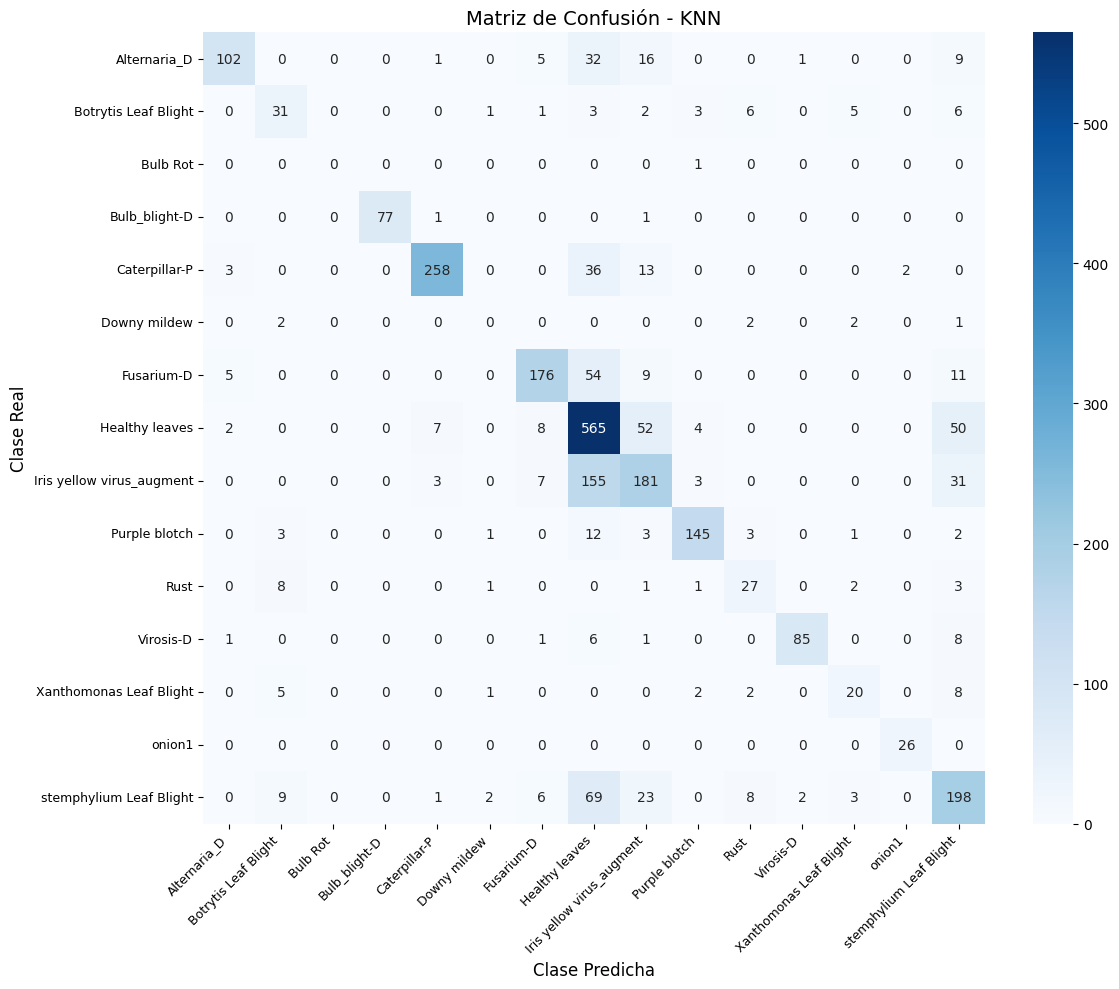

In [21]:
# 8. Visualizar matriz de confusión
visualizar_matriz_confusion(matriz, label_encoder.classes_)

In [22]:
# 9. Análisis de vecinos más cercanos (muestra)
analizar_vecinos_mas_cercanos(
    modelo, X_test_scaled, y_test, 
    X_train_scaled, y_train, n_ejemplos=3
)


ANÁLISIS DE VECINOS MÁS CERCANOS

Ejemplo 1:
   Clase real: 6
   Vecinos encontrados:
      1. Clase: 7, Distancia: 65.5865
   Votación:
      Clase 7: 1 votos
   Predicción final: 7

Ejemplo 2:
   Clase real: 12
   Vecinos encontrados:
      1. Clase: 12, Distancia: 48.3759
   Votación:
      Clase 12: 1 votos
   Predicción final: 12

Ejemplo 3:
   Clase real: 7
   Vecinos encontrados:
      1. Clase: 7, Distancia: 40.0517
   Votación:
      Clase 7: 1 votos
   Predicción final: 7



ANÁLISIS DEL IMPACTO DE K
   K=1: Train=0.9995, Test=0.7147
   K=3: Train=0.8130, Test=0.5442
   K=5: Train=0.6623, Test=0.4686
   K=7: Train=0.5806, Test=0.4448
   K=9: Train=0.5193, Test=0.4271
   K=11: Train=0.4830, Test=0.4104
   K=13: Train=0.4636, Test=0.4055
   K=15: Train=0.4422, Test=0.4014
   K=17: Train=0.4299, Test=0.3904
   K=19: Train=0.4180, Test=0.3896
   K=21: Train=0.4098, Test=0.3825
   K=23: Train=0.4028, Test=0.3764
   K=25: Train=0.3942, Test=0.3707
   K=27: Train=0.3882, Test=0.3677
   K=29: Train=0.3839, Test=0.3639


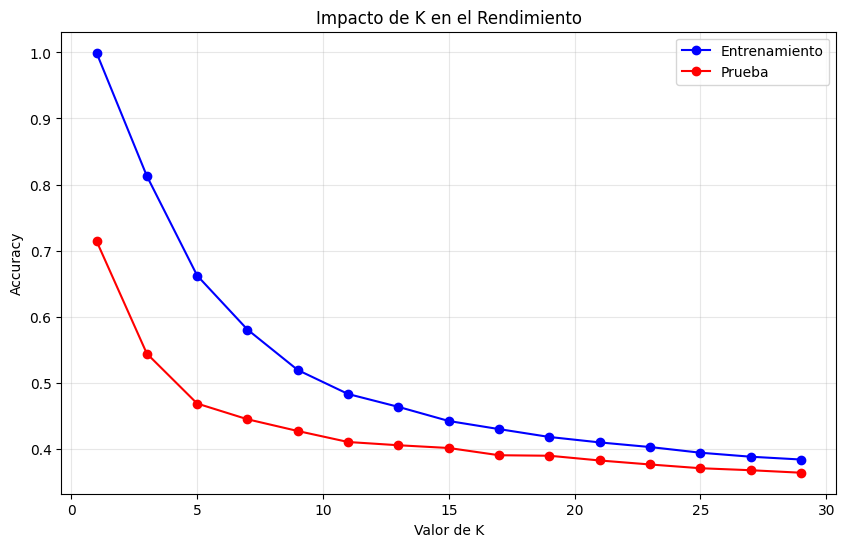


K con menor diferencia train-test: 29
Diferencia: 0.0200


In [23]:
# 10. Análisis del impacto de K
analizar_impacto_k(X_train_scaled, y_train, X_test_scaled, y_test)

In [24]:
# 11. Guardar modelo
joblib.dump(modelo, out_dir/'modelo_knn.pkl')
joblib.dump(scaler, out_dir/'scaler_knn.pkl')
joblib.dump(label_encoder, out_dir/'label_encoder_knn.pkl')
print("\nModelo guardado como 'modelo_knn.pkl'")


Modelo guardado como 'modelo_knn.pkl'


In [25]:
# Análisis de confusión
print("\n" + "="*60)
print("PARES DE CLASES MÁS CONFUNDIDOS")
print("="*60)
        
for i in range(len(label_encoder.classes_)):
    fila = matriz[i]
    if fila.sum() > 0:
        indices_confusion = np.where(fila > 0)[0]
        if len(indices_confusion) > 1:
            max_confusion = 0
            clase_confundida = -1
            for j in indices_confusion:
                if i != j and fila[j] > max_confusion:
                    max_confusion = fila[j]
                    clase_confundida = j
            if clase_confundida >= 0 and max_confusion > 0:
                print(f"{label_encoder.classes_[i]} -> {label_encoder.classes_[clase_confundida]}: {max_confusion} veces")


PARES DE CLASES MÁS CONFUNDIDOS
Alternaria_D -> Healthy leaves: 32 veces
Botrytis Leaf Blight -> Rust: 6 veces
Bulb_blight-D -> Caterpillar-P: 1 veces
Caterpillar-P -> Healthy leaves: 36 veces
Downy mildew -> Botrytis Leaf Blight: 2 veces
Fusarium-D -> Healthy leaves: 54 veces
Healthy leaves -> Iris yellow virus_augment: 52 veces
Iris yellow virus_augment -> Healthy leaves: 155 veces
Purple blotch -> Healthy leaves: 12 veces
Rust -> Botrytis Leaf Blight: 8 veces
Virosis-D -> stemphylium Leaf Blight: 8 veces
Xanthomonas Leaf Blight -> stemphylium Leaf Blight: 8 veces
stemphylium Leaf Blight -> Healthy leaves: 69 veces



PREDICCIÓN:
   Clase: Alternaria_D
   Confianza: 100.00%

Vecinos más cercanos (K=1):
   1. Distancia: 0.0000 (idx: 7020)


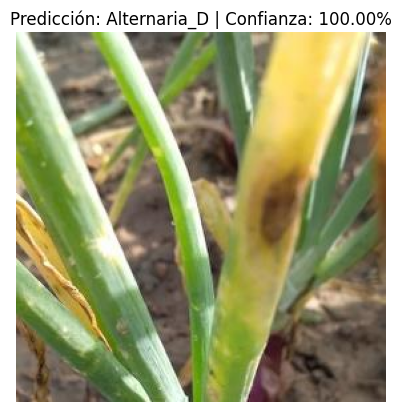

'Alternaria_D'

In [26]:
predecir_imagen("Imagenes_Prueba/Alternaria.jpg")


PREDICCIÓN:
   Clase: Xanthomonas Leaf Blight
   Confianza: 100.00%

Vecinos más cercanos (K=1):
   1. Distancia: 39.7947 (idx: 5802)


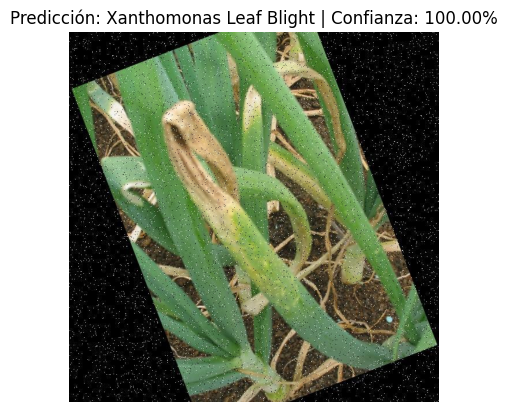

'Xanthomonas Leaf Blight'

In [27]:
predecir_imagen("Imagenes_Prueba/Downy.jpg")


PREDICCIÓN:
   Clase: Iris yellow virus_augment
   Confianza: 100.00%

Vecinos más cercanos (K=1):
   1. Distancia: 0.0000 (idx: 5444)


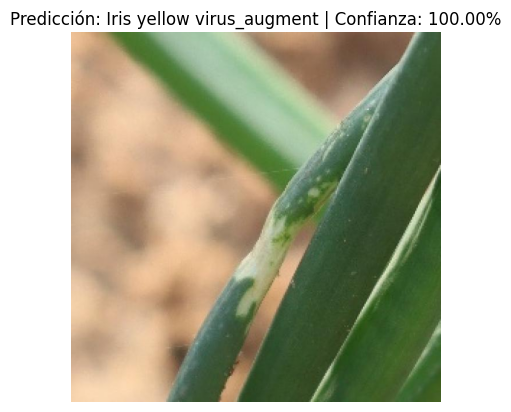

'Iris yellow virus_augment'

In [3]:
predecir_imagen("Imagenes_Prueba/Iris.jpg")


PREDICCIÓN:
   Clase: Purple blotch
   Confianza: 100.00%

Vecinos más cercanos (K=1):
   1. Distancia: 0.0000 (idx: 5786)


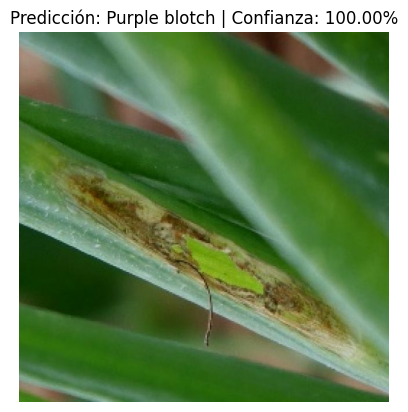

'Purple blotch'

In [4]:
predecir_imagen("Imagenes_Prueba/Purple.jpg")